In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import re
import seaborn as sns

## Importing Data

In [3]:
# importing column labels from imports-85.names
# we also determine which features are numerical and which are categorical
feature_names = []
feature_num = []
feature_cat = []

regex = re.compile('\d+\.\s(\S+):\s\s\s\s+(\S+)')
with open('imports-85.names') as f:
    for line in f:
        match = regex.search(line)
        try:
            feature_names.append(match.group(1))
            if match.group(2) == 'continuous':
                feature_num.append(match.group(1))
            else:
                feature_cat.append(match.group(1))
        except:
            pass

In [4]:
# import data
# read '?' string as nan
df = pd.read_csv('imports-85.data', header=None, dtype=str, na_values='?')

# name the columns
df.columns = feature_names

# drop symboling column
df = df.drop('symboling', axis=1)
feature_names.remove('symboling')
feature_cat.remove('symboling')

# drop all rows with nan
df = df.dropna()

# just a quick glance at the data
df.head(5)

,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
3,164,audi,gas,std,four,sedan,fwd,front,99.80,176.60,...,109,mpfi,3.19,3.40,10.00,102,5500,24,30,13950
4,164,audi,gas,std,four,sedan,4wd,front,99.40,176.60,...,136,mpfi,3.19,3.40,8.00,115,5500,18,22,17450
6,158,audi,gas,std,four,sedan,fwd,front,105.80,192.70,...,136,mpfi,3.19,3.40,8.50,110,5500,19,25,17710
8,158,audi,gas,turbo,four,sedan,fwd,front,105.80,192.70,...,131,mpfi,3.13,3.40,8.30,140,5500,17,20,23875
10,192,bmw,gas,std,two,sedan,rwd,front,101.20,176.80,...,108,mpfi,3.50,2.80,8.80,101,5800,23,29,16430


## Preprocessing

In [5]:
# converting (as read) string values to float
df[feature_num] = df[feature_num].astype(np.float)

In [6]:
# dummifying categorical columns
for feature in feature_cat:
    df = df.merge(pd.get_dummies(df.loc[:, feature]), left_index=True, right_index=True)
df = df.drop(feature_cat, axis=1)

In [7]:
# every column should be of type float64 or uint8 at this point
df.dtypes.nunique()

2

In [8]:
df.nunique().sort_values().head(5)

front     1
gas       2
std       2
turbo     2
four_x    2
dtype: int64

In [9]:
# since a feature with constant value is of no use we drop it from the dataframe
df = df.drop('front', axis=1)

In [10]:
df.head(5)

,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,...,five,four_y,six,three,1bbl,2bbl,idi,mfi,mpfi,spdi
3,164.0,99.8,176.6,66.2,54.3,2337.0,109.0,3.19,3.4,10.0,...,0,1,0,0,0,0,0,0,1,0
4,164.0,99.4,176.6,66.4,54.3,2824.0,136.0,3.19,3.4,8.0,...,1,0,0,0,0,0,0,0,1,0
6,158.0,105.8,192.7,71.4,55.7,2844.0,136.0,3.19,3.4,8.5,...,1,0,0,0,0,0,0,0,1,0
8,158.0,105.8,192.7,71.4,55.9,3086.0,131.0,3.13,3.4,8.3,...,1,0,0,0,0,0,0,0,1,0
10,192.0,101.2,176.8,64.8,54.3,2395.0,108.0,3.50,2.8,8.8,...,0,1,0,0,0,0,0,0,1,0


## Regression via Neural Network

In [11]:
from sklearn import preprocessing
from sklearn.neural_network import MLPRegressor

In [12]:
target_column = 'normalized-losses'

In [13]:
# df_y is flattened to conform with the shape requested by MLPRegressor
df_X = df.loc[:, ~df.columns.isin([target_column])].values
df_y = df.loc[:, df.columns.isin([target_column])].values.flatten()

In [14]:
# fit and transform df_X as neural networks work better with normalized input
scaler_X = preprocessing.StandardScaler()
scaler_X.fit(df_X)
df_X_scaled = scaler_X.fit_transform(df_X)

In [15]:
model = MLPRegressor(activation='logistic', max_iter=1000, hidden_layer_sizes=(200),
                     learning_rate='adaptive', learning_rate_init=0.01, solver='sgd', alpha=0.001,
                     batch_size=20, verbose=True, tol=0.01, early_stopping=True,
                     validation_fraction=0.2, warm_start=False)
model.fit(df_X_scaled, df_y)

Iteration 1, loss = 2925.06640412
Validation score: -0.346135
Iteration 2, loss = 573.75401115
Validation score: 0.001506
Iteration 3, loss = 343.16771200
Validation score: 0.440936
Iteration 4, loss = 189.87337179
Validation score: 0.682906
Iteration 5, loss = 137.14875869
Validation score: 0.719680
Iteration 6, loss = 115.55942977
Validation score: 0.751417
Iteration 7, loss = 88.34151867
Validation score: 0.747100
Iteration 8, loss = 74.09590409
Validation score: 0.781643
Iteration 9, loss = 54.63590930
Validation score: 0.794641
Iteration 10, loss = 37.55051307
Validation score: 0.800329
Iteration 11, loss = 33.11681528
Validation score: 0.773095
Iteration 12, loss = 27.60447334
Validation score: 0.788267
Validation score did not improve more than tol=0.010000 for two consecutive epochs. Setting learning rate to 0.002000
Iteration 13, loss = 34.90818563
Validation score: 0.800318
Iteration 14, loss = 18.04114019
Validation score: 0.799011
Iteration 15, loss = 17.71116652
Validation

MLPRegressor(activation='logistic', alpha=0.001, batch_size=20, beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=200, learning_rate='adaptive',
       learning_rate_init=0.01, max_iter=1000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='sgd', tol=0.01, validation_fraction=0.2,
       verbose=True, warm_start=False)

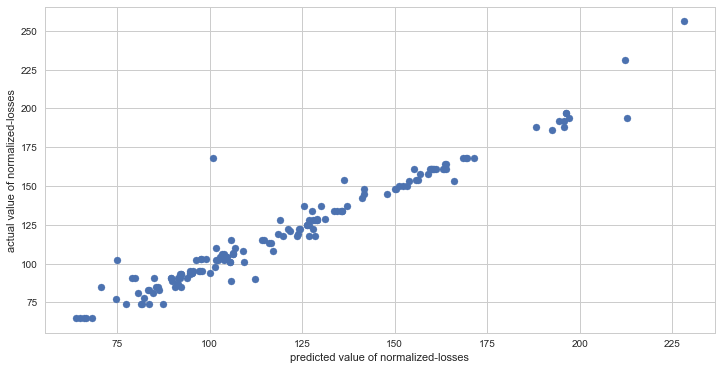

In [16]:
# plotting the result
plt.figure(figsize=(12, 6))
plt.scatter(model.predict(df_X_scaled), df_y)
plt.xlabel('predicted value of normalized-losses')
plt.ylabel('actual value of normalized-losses')

In [17]:
model.score(df_X_scaled, df_y)

0.94714837267262064

### Discussion
--------
Perhaps due to small sample size, if ``random_state`` is not set to ``0``, the model seem to converge to widely different points even with the same parameters. As for the choice of parameters:

* activation function: ``logistic`` seems to work best, i.e. converging to a more desirable result (with loss value below 20, and the final score above 0.8) most frequently. ``relu`` often diverges if the parameters are not carefully controlled for.
* hidden layer size: there does not seem to be any significant performance gain in terms of the final score going beyond 200 nodes. as the sample size is rather small and we are not concerned with computational efficiency at this time, due to the universal approximation theorem and the choice of the activation function, we do not need to experiment with multiple hidden layers.
* solver: ``sgd`` performs better than the default choice ``adam``.
* batch size: 20 seems to work well. due to small sample size, the error manifold is likely to be very non-convex, meaning there are too many local extrema that the model cannot get out of once stuck. the result is that full gradient descent method most likely converges to bad values.
* alpha (penalty) and tolerance: does not seem to affect performance unless set very high. perhaps high values might need to be used to mitigate possible overfitting and further analysis is required.
* early stopping and validation fraction: early stopping is set to ``true`` to deal with overfitting. validation fraction is set to 0.2 as opposed to the default value of 0.1 to somewhat mitigate the problem of the validation sample size being too small.

### Questions
--------
* why does relu fail?
* what are good values for tolerance and penalty?
* how trustworthy is the cross validation method used here?
* what about validation fraction value?
* how do we know if the model was not trained to be overfitted?
* if ``warm_start`` is set to ``True`` and we fit the model over and over again, it is possible to get a score arbitrarily close to 1. why is this the case?

## Linear Regression via Ordinary Least Squares
--------
Simple OLS is employed here as a comparison to the neural network model above. Obviously, without proper model analysis, the result below is grossly overfitted simple linear model.

In [18]:
from sklearn import feature_selection

In [19]:
model = sm.OLS(df_y, df_X)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     10.28
Date:                Fri, 01 Sep 2017   Prob (F-statistic):           7.85e-24
Time:                        14:58:59   Log-Likelihood:                -654.16
No. Observations:                 159   AIC:                             1410.
Df Residuals:                     108   BIC:                             1567.
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -1.3220      1.341     -0.986      0.3

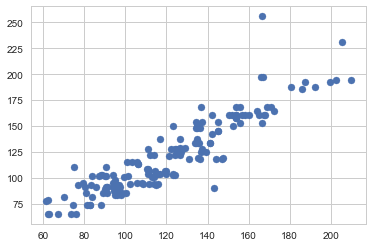

In [20]:
plt.scatter(result.predict(df_X), df_y)

## Dealing with Overfitting

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
def get_average_score(model, n_trials=10, test_split=0.2):
    total_score = 0
    train_score = 0
    test_score = 0
    mape_score = 0
    plt.figure(figsize=(12, 6))
    for i in range(n_trials):
        X_train, X_test, y_train, y_test = train_test_split(
            df_X_scaled, df_y, test_size=test_split)
        model.fit(X_train, y_train)
        total_score += model.score(df_X_scaled, df_y) / n_trials
        train_score += model.score(X_train, y_train) / n_trials
        test_score += model.score(X_test, y_test) / n_trials
        mape_score += (((np.abs(y_test - model.predict(X_test)) / y_test).sum() / y_test.size) * 100) / n_trials
        plt.scatter(model.predict(X_train), y_train, c='b', alpha=0.4)
        plt.scatter(model.predict(X_test), y_test, s=10 ** 2, c='r', alpha=0.8)
    return total_score, train_score, test_score, mape_score

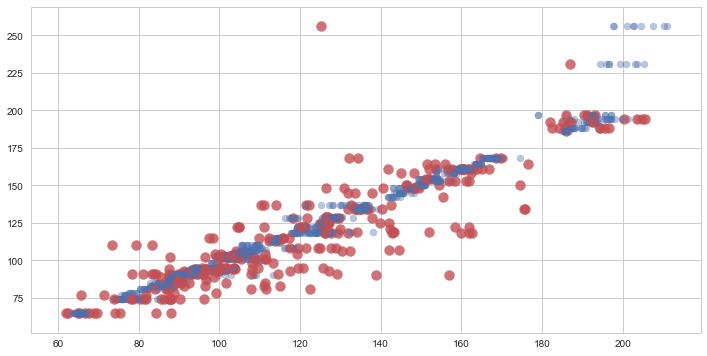

In [23]:
model = MLPRegressor(activation='logistic', max_iter=1000, hidden_layer_sizes=(40),
                 learning_rate='adaptive', learning_rate_init=0.01, solver='sgd', alpha=1,
                 batch_size=20, verbose=False, tol=1, early_stopping=False,
                 validation_fraction=0.2, warm_start=False)

total_score, train_score, test_score, mape_score = get_average_score(model, n_trials=10, test_split=0.2)

In [24]:
print('average score for all samples: {:.3f}'.format(total_score))
print('average score for train samples: {:.3f}'.format(train_score))
print('average score for test samples: {:.3f}'.format(test_score))
print('average mape score for test samples: {:.2f}%'.format(mape_score))

average score for all samples: 0.936
average score for train samples: 0.972
average score for test samples: 0.774
average mape score for test samples: 9.04%


### Discussion
--------
Since the set of validation samples is fixed in the first analysis of MLP, it is hard to check the integrity and the efficacy of the model used. When ``warm_start`` is set to ``True``, it is even possible to get a score arbitrarily close to 1. One possible explanation of this phenomenon would be that a new validation set being set aside for each fit, thus the result from a previous training set leaking into the new validation set in the next run. Aside from this, validation score varies wildly for each fit due to the small sample size. As validation score better represents the true predictive power of the model, we aim for a model that gives high validation score. Parameters are newly optimized for this purpose.

Also mentioned in the description in the file ``import-85.names`` is the use of the mean absolute percentage error (MAPE) metric. So we have tested the model above using the MAPE metric on the validation set and have obtained around 9%, which is better than those cited (11.84% for IBL kNN and 14.12% for linear regression).

Ideally, the discrepancy between the scores between the train samples and test samples should be small (although, higher score for test samples is always desireable). Plotted graph and the huge discrepancy between the two scores suggests that model might be overfitted. To further optimized the parameters, and to see how far the model is overfitted, we need to do a validation curve analysis.

In [28]:
def validation_analysis(n_trials=10, n_iterations=100, test_split=0.2):
    total_score = 0
    train_score = 0
    test_score = 0
    mape_score = 0
    train_scores = []
    test_scores = []
    plt.figure(figsize=(12, 6))
    for i in range(n_trials):
        model = MLPRegressor(activation='logistic', max_iter=1, hidden_layer_sizes=(40),
                     learning_rate='adaptive', learning_rate_init=0.01, solver='sgd', alpha=0.001,
                     batch_size=40, verbose=False, tol=1, early_stopping=False,
                     validation_fraction=0.2, warm_start=True)
        temp_train = []
        temp_test = []
        X_train, X_test, y_train, y_test = train_test_split(
            df_X_scaled, df_y, test_size=test_split)
        for i in range(n_iterations):
            model.fit(X_train, y_train)
            temp_train.append(model.score(X_train, y_train))
            temp_test.append(model.score(X_test, y_test))
        total_score += model.score(df_X_scaled, df_y) / n_trials
        train_score += model.score(X_train, y_train) / n_trials
        test_score += model.score(X_test, y_test) / n_trials
        mape_score += (((np.abs(y_test - model.predict(X_test)) / y_test).sum() / y_test.size) * 100) / n_trials
        plt.plot(temp_train, c='b', alpha=0.4)
        plt.plot(temp_test, c='r', alpha=0.8)
        train_scores.append(temp_train)
        test_scores.append(temp_test)
    plt.ylim(ymin=0.4)
    return total_score, train_score, test_score, mape_score

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


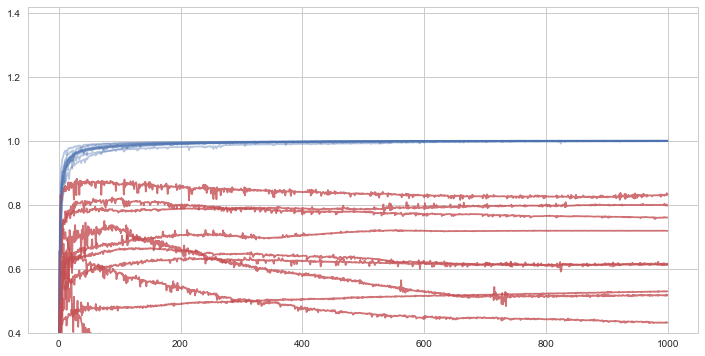

In [29]:
total_score, train_score, test_score, mape_score = validation_analysis(n_trials=10, n_iterations=1000, test_split=0.2)

In [27]:
print('average score for all samples: {:.3f}'.format(total_score))
print('average score for train samples: {:.3f}'.format(train_score))
print('average score for test samples: {:.3f}'.format(test_score))
print('average mape score for test samples: {:.2f}%'.format(mape_score))

average score for all samples: 0.925
average score for train samples: 0.975
average score for test samples: 0.747
average mape score for test samples: 9.32%
